# Визуальная одометрия
-----

**Пайплайн:**
- Выявить коючевые точки (признаки) на изображениях, которые были сделаны с помощью камеры, установленной на движущемся объекте.
- Использовать извлеченные признаки, чтобы найти совпадения между ними на разных фотографиях.
- Использовать найденные совпадения для оценки движения камеры между последующими фотографиями. 
- Использовать оценку движения камеры для построения траектории движения объекта.

In [1]:
# подгружаем необходимые библиотеки
import numpy as np
import cv2
import matplotlib.pyplot as plt
from m2bk import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(42)

## 0 - Загрузка и визуализация данных
Удобный класс обработчика набора данных для чтения и итерирования по ним доступен в локальном пакете. Данные взяты из симулятора CARLA.

In [2]:
dataset_handler = DatasetHandler()
print('Done!')

/Users/almuravtsev/Documents/github_important/ya-profi-preparation/datasets/visual-odometry-data/rgb/frame_00001.png
/Users/almuravtsev/Documents/github_important/ya-profi-preparation/datasets/visual-odometry-data/rgb/frame_00002.png
/Users/almuravtsev/Documents/github_important/ya-profi-preparation/datasets/visual-odometry-data/rgb/frame_00003.png
/Users/almuravtsev/Documents/github_important/ya-profi-preparation/datasets/visual-odometry-data/rgb/frame_00004.png
/Users/almuravtsev/Documents/github_important/ya-profi-preparation/datasets/visual-odometry-data/rgb/frame_00005.png
/Users/almuravtsev/Documents/github_important/ya-profi-preparation/datasets/visual-odometry-data/rgb/frame_00006.png
/Users/almuravtsev/Documents/github_important/ya-profi-preparation/datasets/visual-odometry-data/rgb/frame_00007.png
/Users/almuravtsev/Documents/github_important/ya-profi-preparation/datasets/visual-odometry-data/rgb/frame_00008.png
/Users/almuravtsev/Documents/github_important/ya-profi-preparati

Обработчик набора данных содержит 45 кадров. Каждый кадр содержит изображение RGB и карту глубины, полученную с одинаковым интервалом времени при движении на камеры, и версию изображения RGB в градациях серого, которая будет использоваться для вычислений. 

Готовая матрица калибровки камеры **K** также хранится в обработчике набора данных.

При создании объекта обработчика набора данных все кадры будут автоматически прочитаны и загружены. Доступ к содержимому кадра можно получить с помощью аттрибутов `images`, `images_rgb`, `depth_maps` вместе с номером запрошенного кадра. Посмотрите, как получить доступ к изображениям (оттенки серого), изображениям RGB (3-канальный цвет), картам глубины и матрице калибровки камеры в приведенном ниже примере.

**Примечание (карты глубины)**: Максимальное расстояние глубины равно 1000. Это значение глубины показывает, что выбранный пиксель находится на расстоянии не менее 1000 м (1 км) от камеры, однако точное расстояние этого пикселя от камеры неизвестно. Наличие таких точек в дальнейшей оценке траектории может повлиять на точность траектории.

In [3]:
print(dataset_handler.images[0])

[[109 108 108 ...  32  37  36]
 [109 109 109 ...  51  62  48]
 [109 109 109 ...  36  35  26]
 ...
 [142 142 143 ... 125 124 126]
 [137 143 147 ... 136 129 124]
 [134 140 141 ... 134 129 127]]


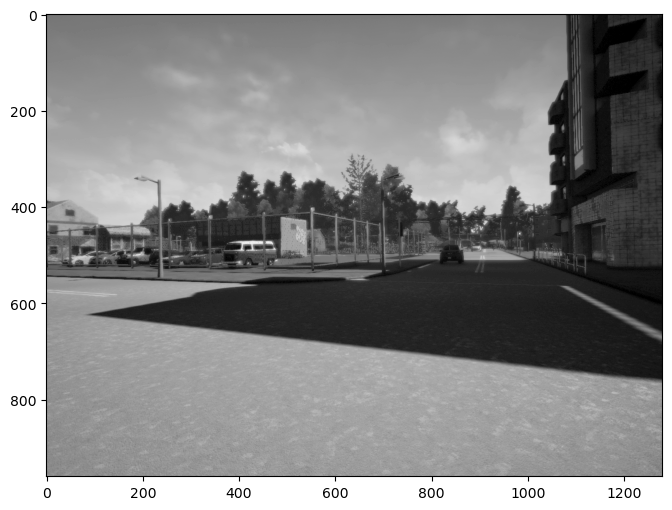

In [4]:
image = dataset_handler.images[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

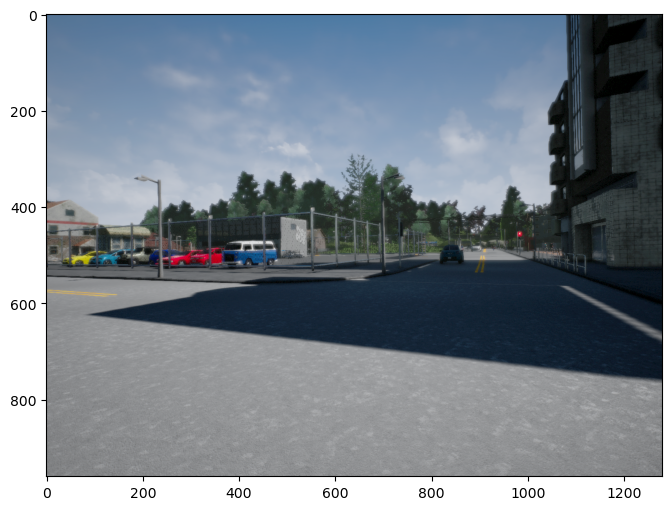

In [5]:
image_rgb = dataset_handler.images_rgb[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

### Если есть карта глубины, это хорошо, если нет, ничего страшного

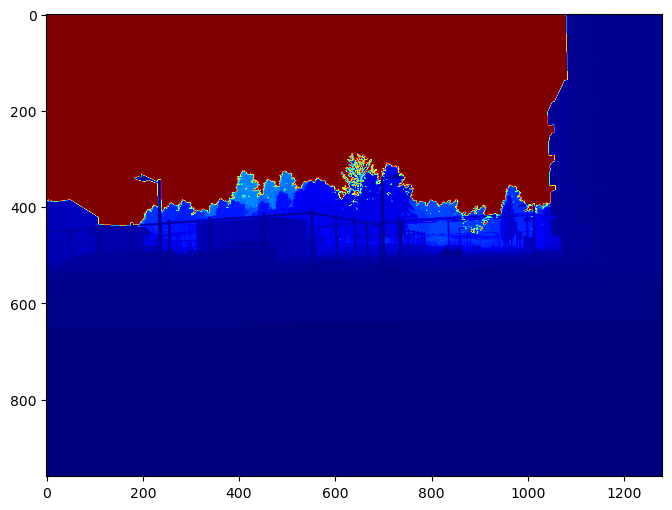

In [6]:
i = 0
depth = dataset_handler.depth_maps[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')

In [7]:
depth

array([[1000.   , 1000.   , 1000.   , ...,   14.607,   14.6  ,   14.593],
       [1000.   , 1000.   , 1000.   , ...,   14.607,   14.6  ,   14.593],
       [1000.   , 1000.   , 1000.   , ...,   14.607,   14.6  ,   14.593],
       ...,
       [   1.972,    1.971,    1.971, ...,    1.87 ,    1.87 ,    1.87 ],
       [   1.967,    1.967,    1.967, ...,    1.866,    1.866,    1.866],
       [   1.963,    1.963,    1.963, ...,    1.863,    1.863,    1.862]])

In [8]:
print("Размеры карты глубин: {0}".format(depth.shape))
v, u = depth.shape
depth_val = depth[v-1, u-1]
print("Значение глубины самого нижнего правого пикселя карты глубины кадры {0} равно {1:0.3f}".format(i, depth_val))

Размеры карты глубин: (960, 1280)
Значение глубины самого нижнего правого пикселя карты глубины кадры 0 равно 1.862


In [9]:
dataset_handler.k

array([[640.,   0., 640.],
       [  0., 480., 480.],
       [  0.,   0.,   1.]], dtype=float32)

Для доступа к произвольному кадру используйте индекс изображения, как показано в примерах ниже. Убедитесь, что индексы находятся в пределах количества кадров в наборе данных. Доступ к количеству кадров в наборе данных можно получить с помощью атрибута num_frames.

In [10]:
# Number of frames in the dataset
print(dataset_handler.num_frames)

46


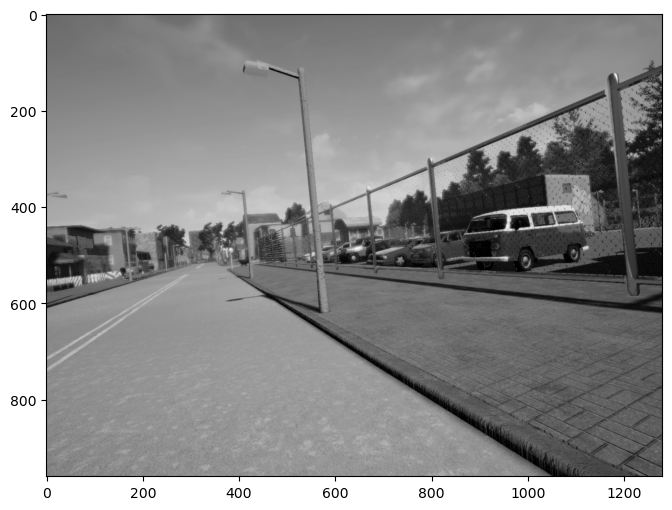

In [11]:
i = 35
image = dataset_handler.images[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

## 1 - Извлечение признаков

### 1.1 - Извлечение признаков из изображения

**Задание**: Реализовать извлечение признаков из одного изображения. Вы можете использовать любой дескриптор признаков по вашему выбору, например, ORB или SIFT.



***Опционально***: Попробуйте извлечь функции с разными дескрипторами, такими как SIFT, ORB, SURF и BRIEF. Вы также можете попробовать использовать детекторы, такие как углы Харриса или FAST, и соединить их с дескриптором. Наконец, попробуйте изменить параметры алгоритмов.

In [12]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    orb = cv2.ORB_create(nfeatures=2000)
    kp = orb.detect(image, None)
    kp , des = orb.compute(image, kp)
    return kp, des

In [13]:
i = 1
image = dataset_handler.images[i]
kp, des = extract_features(image)
print("Number of features detected in frame {0}: {1}\n".format(i, len(kp)))

print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp[0].pt)))

Number of features detected in frame 1: 2000

Coordinates of the first keypoint in frame 1: (521.0, 358.0)


In [14]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(display)

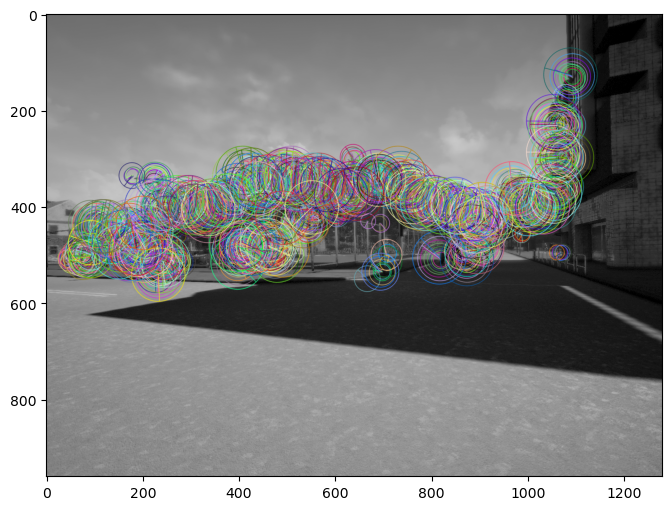

In [15]:
# Optional: visualizing and experimenting with various feature descriptors
i = 0
image = dataset_handler.images[i]

visualize_features(image, kp)

### 1.2 - Извлечение признаков из каждого изображения в наборе данных

In [16]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []
    
    for img in images:
        kp, des = extract_features_function(img)
        kp_list.append(kp)
        des_list.append(des)
    
    return kp_list, des_list

In [17]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

i = 1
print("Количество признаков обнаружено в кадре {0}: {1}".format(i, len(kp_list[i])))
print("Координаты первой ключевой точки в кадре {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Длина массива изображений: {0}".format(len(images)))

Количество признаков обнаружено в кадре 1: 2000
Координаты первой ключевой точки в кадре 1: (521.0, 358.0)

Длина массива изображений: 46


## 2 - Сопоставление признаков

In [18]:
def match_features(des1, des2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    # bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # matches = bf.match(des1,des2)
    # matches = sorted(matches, key = lambda x:x.distance)

    FLANN_INDEX_LSH = 6 
    index_params = dict(algorithm = FLANN_INDEX_LSH,
                        table_number = 6,
                        key_size = 12,
                        multi_probe_level = 1)
    search_params = dict(checks = 50)
    
    # Initiate FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Find matches with FLANN
    matches = flann.knnMatch(des1, des2, k=2)
    
    return matches

In [19]:
i = 0
des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
print("Количество признаков, совпадающих в кадрах {0} и {1}: {2}".format(i, i+1, len(match)))

# Remember that a matcher finds the best matches for EACH descriptor from a query set

Количество признаков, совпадающих в кадрах 0 и 1: 2000


In [20]:
def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    matches -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = [m for m, n in match if m.distance < (dist_threshold * n.distance)]
    
    return filtered_match

In [21]:
# Optional
i = 0
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2)

dist_threshold = 0.8
filtered_match = filter_matches_distance(match, dist_threshold)

print("Количество совпадений в кадрах {0} и {1} после фильтрации по расстоянию: {2}".format(i, i+1, len(filtered_match)))

Количество совпадений в кадрах 0 и 1 после фильтрации по расстоянию: 1212


In [22]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

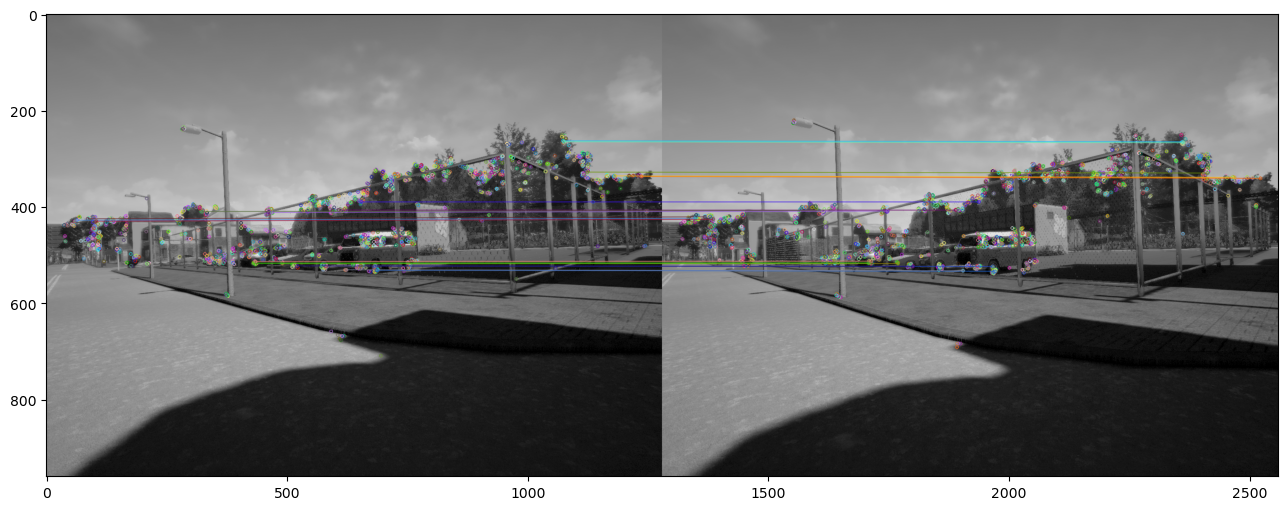

In [23]:
# Визуализируйте первые n совпадений, поставьте n = None чтобы отобразить все совпадения
# установите filtering = True если хотите использовать фильтрацию совпадений, иначе поставьте False
n = 20
filtering = True

i = 26
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    dist_threshold = 0.5
    match = filter_matches_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])

### 2.2 - Сопоставление признаков в каждой последующей паре изображений в наборе данных


***И фильтрация***:

In [24]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = []
    for i in range(len(des_list) - 1):
        matches.append(match_features(des_list[i], des_list[i+1]))
    
    return matches

In [25]:
matches = match_features_dataset(des_list, match_features)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 0 and 1: 2000


In [26]:
# Optional
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = []
    
    for match in matches:
        filtered_matches.append(filter_matches_distance(match, dist_threshold))
    
    return filtered_matches

In [27]:
dist_threshold = 0.5

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

if len(filtered_matches) > 0:
    
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = True
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 26
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

Number of filtered matches in frames 26 and 27: 283


## 3 - Оценка траектории


### 3.1 - Оценка движения камеры между парой изображений

- Если вы решите использовать PnP, вам понадобятся карты глубины кадра, и они предоставляются с обработчиком набора данных.


***Опционально***: Можно реализовать оценку траектории движения камеры с помощью PnP, PnP с RANSAC и Essential Matrix

In [28]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = [] # in 2D
    image2_points = [] # in 2D
    objectpoints = [] # in 3D
    
    ### START CODE HERE ###
    # Iterate through the matched features
    for m in match:
        # Get the pixel coordinates of features f[k - 1] and f[k]
        u1, v1 = kp1[m.queryIdx].pt
        u2, v2 = kp2[m.trainIdx].pt

        # Get the scale of features f[k - 1] from the depth map
        s = depth1[int(v1), int(u1)]

        # Check for valid scale values
        if s < 1000:
            # Transform pixel coordinates to camera coordinates using the pinhole camera model
            p_c = np.linalg.inv(k) @ (s * np.array([u1, v1, 1]))

            # Save the results
            image1_points.append([u1, v1])
            image2_points.append([u2, v2])
            objectpoints.append(p_c)

    # Convert lists to numpy arrays
    objectpoints = np.vstack(objectpoints)
    imagepoints = np.array(image2_points)
    

    # Determine the camera pose from the Perspective-n-Point solution using the RANSAC scheme
    _, rvec, tvec, _ = cv2.solvePnPRansac(objectpoints, imagepoints, k, None)

    # Convert rotation vector to rotation matrix
    rmat, _ = cv2.Rodrigues(rvec)
    ### END CODE HERE ###
    
    return rmat, tvec, image1_points, image2_points

In [29]:
i = 26

match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

Estimated rotation:
 [[ 9.99958186e-01 -8.63653939e-03  3.00606349e-03]
 [ 8.63675716e-03  9.99962701e-01 -5.94686752e-05]
 [-3.00543777e-03  8.54288290e-05  9.99995480e-01]]
Estimated translation:
 [[ 0.0212496 ]
 [ 0.0027444 ]
 [-0.38446852]]


In [30]:
len(image1_points)

200

**Ожидаемый формат вывода**:

Убедитесь, что ваша предполагаемая матрица вращения и вектор перемещения имеют тот же формат, что и заданные начальные значения.

```
rmat = np.eye(3)
tvec = np.zeros((3, 1))

print("Initial rotation:\n {0}".format(rmat))
print("Initial translation:\n {0}".format(tvec))
```


```
Initial rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Initial translation:
 [[0.]
 [0.]
 [0.]]
```

**Визуализация движения камеры**:
Вы можете использовать `visualize_camera_movement` доступный в локальном пакете. Эта функция визуализирует окончательные совпадения изображений из пары изображений, соединенных стрелкой, соответствующей направлению движения камеры. (when `is_show_img_after_mov = False`). Описание функции:
```
Arguments:
image1 -- the first image in a matched image pair (RGB or grayscale)
image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
image2 -- the second image in a matched image pair (RGB or grayscale)
image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
is_show_img_after_mov -- a boolean variable, controling the output (read image_move description for more info) 

Returns:
image_move -- an image with the visualization. When is_show_img_after_mov=False then the image points from both images are visualized on the first image. Otherwise, the image points from the second image only are visualized on the second image

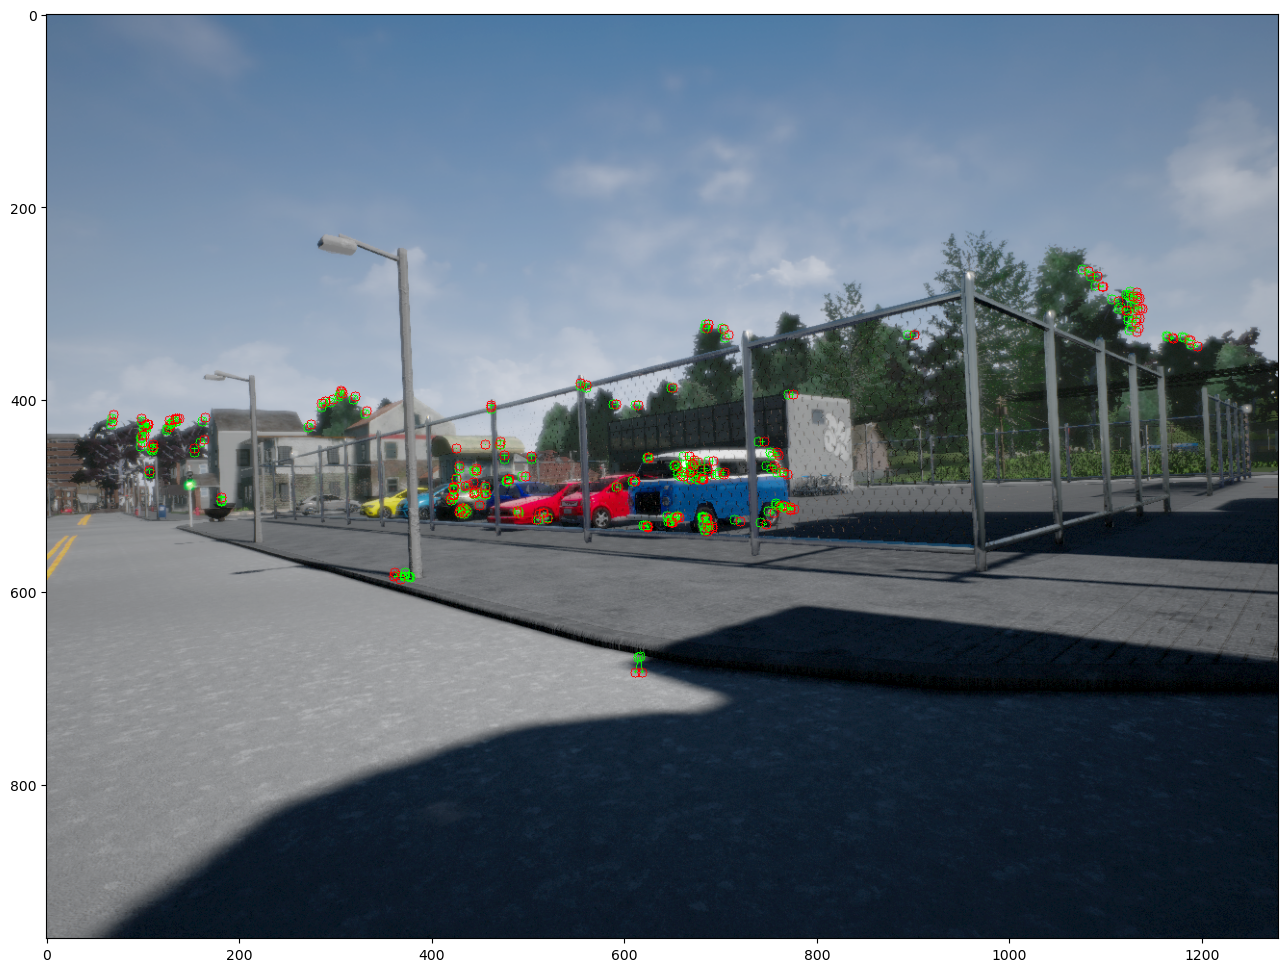

In [31]:
i = 26
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

# These visualizations might be helpful for understanding the quality of image points selected for the camera motion estimation

### 3.2 - Оценка траектории камеры

**Задание**: Реализуйте оценку траектории камеры с помощью визуальной одометрии. В частности, реализуйте оценку движения камеры для каждой последующей пары изображений в наборе данных с помощью функции, которую вы написали в предыдущем разделе.

***Замечание***: Не забывайте, что пары изображений не являются независимыми друг от друга. i-я и (i + 1)-я пары изображений имеют общую часть

In [32]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[]):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function

    """
    trajectory = np.zeros((3, len(matches) + 1))
    robot_pose = np.zeros((len(matches) + 1, 4, 4))
    
    # Initialize camera pose
    robot_pose[0] = np.eye(4)

    for i in range(len(matches)):
        print(i)
        # Оценка движения камеры между изображениями 
        rmat, tvec, image1_points, image2_points = estimate_motion(matches[i], kp_list[i], kp_list[i + 1], k, depth_maps[i]) #была здесь ошибка kp_list[i + 1]
        current_pose = np.eye(4)
        current_pose[0:3, 0:3] = rmat #матрица поворота 
        current_pose[0:3, 3] = tvec.T #вектор перемещения
        # Полученное положение робота
        robot_pose[i + 1] = robot_pose[i] @ np.linalg.inv(current_pose)
        
        # Вычисление текущего положение камеры 
        position = robot_pose[i + 1] @ np.array([0., 0., 0., 1.])#xyz из матрицы однородных преобразований 
        
        # Для построения траектории 
        trajectory[:, i + 1] = position[0:3]
    return trajectory

In [33]:
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, filtered_matches, kp_list, k, depth_maps=depth_maps)
print('Done!')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
Done!


In [34]:
i = 20
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

Camera location in point 20 is: 
 [[-1.41970664]
 [ 0.10260134]
 [ 6.9575185 ]]

Length of trajectory: 46


**Expected Output**:

```
Camera location in point i is: 
 [[locXi]
 [locYi]
 [locZi]]```
 
 In this output: locXi, locYi, locZi are the coordinates of the corresponding i-th camera location

### Визуализируйте свои результаты

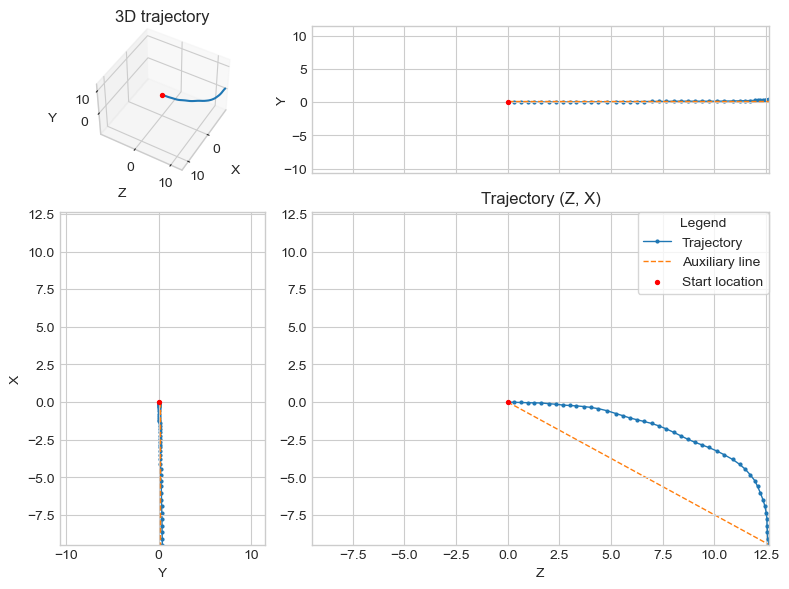

In [35]:
visualize_trajectory(trajectory)